## IMPORTS AND PARAMETERS

In [1]:
from IPython.display import clear_output
from datetime import datetime
from tqdm import tqdm

import numpy as np


from data import DataLoader, Process
from models import Models

In [2]:
TRAIN_DATASET_PATH = "./src/train/"
VAL_DATASET_PATH = "./src/val/"

METRICS_PATH = "./training/checkpoint.txt"
OUTPUTS_PATH ="./training/output"

GENERATOR_SAVE_PATH = "./training/generator"
DISCRIMINATOR_SAVE_PATH = "./training/discriminator"

IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNEL = (512, 512,3)
DATA_LENGTH = 14630
EPOCHS = 100
AUTO_SAVE_PERIOT = 5
BATCH_SIZE = 4
BATH_COUNT = int(DATA_LENGTH / BATCH_SIZE)
TRAIN_TOPIC = datetime.now().strftime("%m_%d-%H_%M")
LATENT_DIM = 100  
NUM_CLASSES = 3  


global d_real_losses,d_fake_losses,g_losses 
d_real_losses,d_fake_losses,g_losses = [],[],[]



## DATA

Loading data from:  ./src/train/
Found 14630 files belonging to 3 classes.
Data loaded successfully.
Images scaled to [0,1].
CURRENT DATASET SCALE: True
IMAGE TYPE: float32


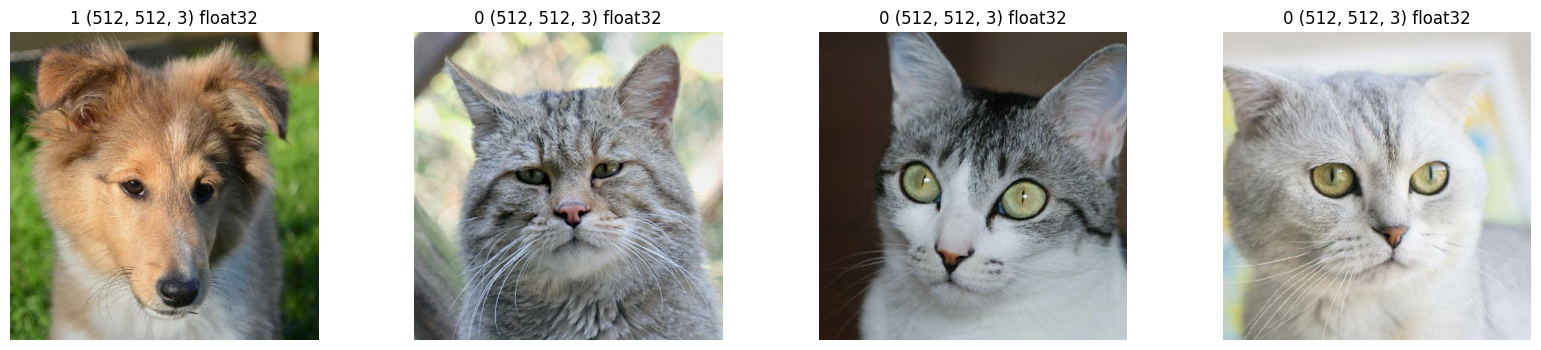

In [ ]:
dataloader = DataLoader(batch_size=BATCH_SIZE,image_size=(IMAGE_WIDTH,IMAGE_HEIGHT))
data = dataloader.load_data(TRAIN_DATASET_PATH)
data = data.take(100)
example_imgs,example_lbls = dataloader.show_sample(1)

## MODEL

In [4]:
models = Models()
models.build_models(img_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNEL),latent_dim=LATENT_DIM,num_classes=NUM_CLASSES)
generator = models.generator
discriminator = models.discriminator
gan = models.gan


## TRANSFER MODEL

## TRAINING

In [5]:
process_follower = Process()

In [6]:
def get_random_latent_vector():
    return np.random.normal(0,1,(BATCH_SIZE,LATENT_DIM))

def get_random_labels():
    return np.random.randint(0,NUM_CLASSES,BATCH_SIZE)

def get_test_input():
    noise = np.random.normal(0,1,(3,LATENT_DIM))
    label = np.array([0,1,2])
    return noise,label

def train(gan,discriminator,generator,data,process_follower,test_noise,test_label):
    
    real = np.ones((BATCH_SIZE,1))
    fake = np.zeros((BATCH_SIZE,1))
    
    for epoch in tqdm(range(EPOCHS)):
        ep_d_loss_fake = 0
        ep_d_loss_real = 0
        ep_g_loss = 0
        
        counter = 0
        for batch in tqdm(data):
            
            images,labels = batch
            
            #train discriminator with real data
            d_loss_real = discriminator.train_on_batch([images,labels],real)
            
            # train discriminator with fake data
            noise = get_random_latent_vector()
            random_labels = get_random_labels()
            gen_imgs = generator.predict([noise,random_labels],verbose=None)
            d_loss_fake = discriminator.train_on_batch([gen_imgs,random_labels],fake) 
            
            # train generator via gan model, data goes through noise->predicted->1 (as real)
            noise = get_random_latent_vector()
            random_labels = get_random_labels()
            g_loss = gan.train_on_batch([noise,random_labels],real)
            
            # metrics
            counter += 1
            ep_d_loss_fake += d_loss_fake
            ep_d_loss_real += d_loss_real
            ep_g_loss += g_loss
        
        ep_d_loss_real = ep_d_loss_real / counter
        ep_d_loss_fake = ep_d_loss_fake / counter
        ep_g_loss = ep_g_loss / counter
        
        interval_test_sample = models.test_generator(test_noise,test_label)
        
        clear_output()
        print(f"{TRAIN_TOPIC} ep {epoch}")
        print("d_loss_real: ",ep_d_loss_real)
        print("d_loss_fake: ",ep_d_loss_fake)
        print("g_loss: ",ep_g_loss)
        
        process_follower.show_outputs(ep_d_loss_real,ep_d_loss_fake,g_loss,interval_test_sample)
        if epoch % AUTO_SAVE_PERIOT == 0:
            process_follower.save_checkpoint(epoch,TRAIN_TOPIC,generator,discriminator,ep_d_loss_real,ep_d_loss_fake,ep_g_loss,interval_test_sample,GENERATOR_SAVE_PATH,DISCRIMINATOR_SAVE_PATH,METRICS_PATH,OUTPUTS_PATH)

                    
            
            
        
    

## TRAIN

In [7]:
test_noises,test_labels = get_test_input()
train(gan,discriminator,generator,data,process_follower,test_noises,test_labels)


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [10:43<?, ?it/s]


ValueError: Data cardinality is ambiguous:
  x sizes: 2, 2
  y sizes: 4
Make sure all arrays contain the same number of samples.

## TESTS